* nov05 2025-02-05

> A WebDataset is an instance of IterableDataset.

In [1]:
%pwd

'd:\\github\\udacity-nd009t-capstone-starter\\examples'

In [5]:
## windows cmd to launch notepad to edit aws credential file
# !notepad C:\Users\guido\.aws\config
!notepad C:\Users\guido\.aws\credentials

In [7]:
## reset the session after updating credentials
import boto3 # type: ignore
boto3.DEFAULT_SESSION = None
import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore

# Extract and print the account ID
sts_client = boto3.client('sts')
response = sts_client.get_caller_identity() 
account_id = response['Account']

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## Go to "IAM - Roles", search for "SageMaker", find the execution role.
    voclabs_role_arn = role_arn
    sagemaker_role_arn = "arn:aws:iam::570668189909:role/service-role/AmazonSageMaker-ExecutionRole-20250126T194519"
session = sagemaker.Session()  ## "default"
region = session.boto_region_name
bucket = session.default_bucket()

print(f"Current AWS Account ID: {account_id}")
print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print(f"Role voclabs ARN: {voclabs_role_arn}") ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
print("SageMaker Role ARN: {}".format(sagemaker_role_arn)) 

## generate secrets.env. remember to add it to .gitignore  
import wandb
wandb.sagemaker_auth(path="../secrets") 

## get my own AWS account info
def get_secrets(name):
    path = '../secrets/' + name
    with open(path, 'r') as file:
        for line in file:
            return line.strip()
aws_account_number = get_secrets('aws_account_number')
aws_account_profile = get_secrets('aws_account_profile')

[02/05/25 22:33:53] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=60311;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=420495;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[02/05/25 22:33:57] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=642212;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=24243;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5971\5971]8;;\
                             Role path.                                                                            

Current AWS Account ID: 570668189909
AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-570668189909
Role voclabs ARN: arn:aws:iam::570668189909:role/voclabs
SageMaker Role ARN: arn:aws:iam::570668189909:role/service-role/AmazonSageMaker-ExecutionRole-20250126T194519


In [4]:
## example code of webdataset creating tar files locally
import webdataset as wds
import io
import json
print("👉 WebDataset version:", wds.__version__)
tar_stream = io.BytesIO()
base_name = "100313"
with wds.TarWriter(tar_stream) as sink:
    with open("../data/bin-images/100313.jpg", "rb") as f:
        image_data = f.read()
    with open("../data/metadata/100313.json", "rb") as f:
        label = json.load(f)['EXPECTED_QUANTITY']  ## load json binary
    with open("../data/metadata/100313.json", "rb") as f:
        metadata_data = f.read()
    # Save as WebDataset sample
    sink.write({
        "__key__": f"{base_name}",
        "image": image_data,
        "label": str(label),
        "metadata": metadata_data,
    })
# Once the tar file is in memory, save to local file
tar_stream.seek(0)
with open("../data/test/test.tar", "wb") as f:
    f.write(tar_stream.getvalue())
!tar -tf ../data/test/test.tar

👉 WebDataset version: 0.2.100
100313.image
100313.label
100313.metadata


<class 'int'> 1
<class 'str'> {
    "BIN_FCSKU_DATA": {
        "B00O0WRO08": {

<class 'PIL.JpegImagePlugin.JpegImageFile'>


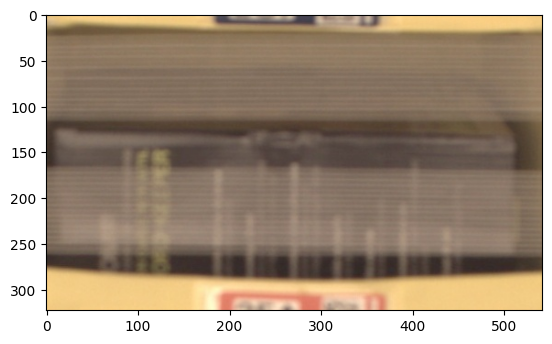

In [10]:
## example code of WebDataset converting a local .tar file to training data formats.
## The .tar file contains .jpg in binary format and label in string format.
import webdataset as wds
# import matplotlib
# matplotlib.use('Agg')  # Use the Agg backend
# matplotlib.use('TkAgg')  # Switch back to an interactive backend?
import matplotlib.pyplot as plt
from PIL import Image
import io
train_dataset = (
    wds.WebDataset("../data/test/test.tar", shardshuffle=False)
        ## names have to be the same with the WebDataset keys
        .to_tuple("image", "label", "metadata")  
        .map_tuple(
            lambda x:x, 
            lambda x:int(x.decode()), 
            lambda x:x.decode(),
        )
)
for image,label,metadata in iter(train_dataset):
    print(type(label), label)
    print(type(metadata), metadata[:50])
    img = Image.open(io.BytesIO(image))
    print(type(img))
    # img.show()  ## popup window
    plt.imshow(img)
    plt.show()

<class 'str'> 5
<class 'PIL.JpegImagePlugin.JpegImageFile'>


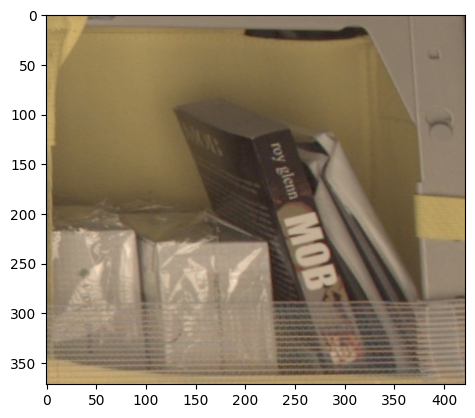

Exception ignored in: <function Pipe.__del__ at 0x0000019F4E4BF640>
Traceback (most recent call last):
  File "d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\webdataset\gopen.py", line 121, in __del__
    self.close()
  File "d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\webdataset\gopen.py", line 109, in close
    self.wait_for_child()
  File "d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\webdataset\gopen.py", line 83, in wait_for_child
    raise IOError(f"{self.args}: exit {self.status} (read) {info}")
OSError: (('aws s3 cp s3://p5-amazon-bin-images/webdataset/train/train-shard-000000.tar -',), {'shell': True, 'bufsize': 8192}): exit 1 (read) {}


In [8]:
## test code streaming data from s3. 
## pay attention to the object types.
import webdataset as wds
import matplotlib.pyplot as plt
from PIL import Image
import io
try:
    s3_uri = "s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000001}.tar"
    path = f"pipe:aws s3 cp {s3_uri} -"  ## write to standard output (stdout)
    train_dataset = (
        wds.WebDataset(
                path, 
                shardshuffle=True,
                # nodesplitter=wds.split_by_worker,  ## distributed training
            )
            .shuffle(1000)  # Shuffle dataset 
            ## The tuple names have to be the same with the WebDataset keys
            ## check the "scripts_process/*convert_to_webdataset*.py" files
            .to_tuple("image", "label")  ## Tuple of image and label
            .map_tuple(
                lambda x:Image.open(io.BytesIO(x)),  # Apply the train transforms to the image
                lambda x:x.decode(),
            )  
    ) 
    for image,label in iter(train_dataset):
        print(type(label), label)
        # img = Image.open(io.BytesIO(image))
        print(type(image))
        plt.imshow(image)
        plt.show()
        break
except Exception as e:
    print(e)

In [11]:
%%writefile webdataset_ddp.py
## test code SageMaker DDP + Torch DDP
import webdataset as wds
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, IterableDataset
# from torch.utils.data.distributed import DistributedSampler  ## ⚠️
import numpy as np
import time

import multiprocessing as mp
print("👉 Multiprocessing start method:", mp.get_start_method(allow_none=True))
# if mp.get_start_method(allow_none=True) != 'spawn':
#     torch.multiprocessing.set_start_method('spawn')  

def key_transform(x):
    return int(x)

class image_transform:
    def __call__(self, x):
        return Image.open(io.BytesIO(x))
    
train_transform = transforms.Compose([
    image_transform(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])  

def label_transform(x):
    return torch.tensor(int(x.decode()))

class WebDatasetDDP(IterableDataset):
    def __init__(self,
                 path, 
                 *args, 
                 world_size=1, 
                 rank=0,  
                 shuffle_buffer_size=1000,
                 num_samples=0,
                 shardshuffle=True,
                 empty_check=False,
                 key_transform=None,
                 train_transform=None,
                 label_transform=None,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.dataset = (
            wds.WebDataset(
                path, 
                shardshuffle=shardshuffle,
                # nodesplitter=wds.split_by_worker,
                empty_check=empty_check, 
            )
            .shuffle(shuffle_buffer_size)  # Shuffle dataset 
            ## The tuple names have to be the same with the WebDataset keys
            ## check the "scripts_process/*convert_to_webdataset*.py" files
            .to_tuple("__key__", "image", "label")  ## Tuple of image and label
            .map_tuple(
                key_transform,
                train_transform,  # Apply the train transforms to the image
                ## lambda function can't not be pickled, hence cause error when num_workers>1 
                label_transform,  
            )
        )
        self.world_size = world_size
        self.rank = rank
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples
    
    def __iter__(self): 
        for key,image,label in self.dataset:
            if key%self.world_size == self.rank:  ## Ensure each GPU gets different data
                yield (image, label)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = [torch.tensor(np.array(image)) for image in images] 
    # Stack the images into a single tensor (this assumes the images have the same size)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

def main():
    s3_uri = "s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000000}.tar"
    path = f"pipe:aws s3 cp {s3_uri} -"  ## write to standard output (stdout)
    train_dataset = (
        WebDatasetDDP(
            path, 
            world_size=2, 
            rank=0, 
            shuffle_buffer_size=1000,
            num_samples=1000,
            shardshuffle=True,
            empty_check=False,
            key_transform=key_transform,
            train_transform=train_transform,
            label_transform=label_transform,
        )
    ) 
    # ## ⚠️ DistributedSampler doesn't work with IterableDataset
    # train_sampler = DistributedSampler(
    #     train_dataset,
    #     num_replicas=2,  ## number of GPUs
    #     rank=0,  ## global rank
    #     shuffle=False,
    #     drop_last=True,
    # )
    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(256/2),  ## 2 GPUs 
        shuffle=False,  ## Don't shuffle for Distributed Data Parallel (DDP)  
        # sampler=train_sampler, # ⚠️ Distributed Sampler causes error
        # num_workers=2, # ⚠️ Cause error in windows
        # persistent_workers=True,
        pin_memory=True,
        collate_fn=collate_fn,
    )
    print(f"train_loader length: {len(train_loader)}")
    print(f"train_loader.dataset length: {len(train_loader.dataset)}")
    for batch_idx, batch in enumerate(train_loader):
        print(batch_idx, len(batch[0]), len(batch[1]))
        
if __name__ == "__main__":
    start_time = time.time()
    main()
    end_time = time.time()
    print(f"👉 Execution Time: {end_time-start_time} seconds")

## On Windows...
## 8 workers, 31.25 s
## 4 workers, 29.26 s
## 2 workers, 29.40 s
## 1 workers, 20.52 s

## $ cd examples
## $ python -m webdataset_ddp

Overwriting webdataset_ddp.py


```powershell
(sagemaker_py310) PS D:\github\udacity-nd009t-capstone-starter\starter> python -m webdataset_ddp
👉 Multiprocessing start method: None
train_loader length: 8
train_loader.dataset length: 1000
0 128 128
1 128 128
2 128 128
3 128 128
4 8 8
👉 Execution Time: 22.818089962005615 seconds
```

* ⚠️🟢 Issue: `plt.show(img)` caused Jupyter kernal crash. It is **libiomp5md.dll** that causes the problem.  

    ✅ Well, I just removed some conda envs and reinstalled this one `awsmle_py310`.  

    > The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click here for more info. 
View Jupyter log for further details.

    > 15:18:16.283 [error] Disposing session as kernel process died ExitCode: 3, Reason: OMP: Error #15: Initializing `libiomp5md.dll`, but found libiomp5md.dll already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.

    ❌ [Solution](https://community.anaconda.cloud/t/omp-error-15-initializing-libiomp5md-dll-but-found-libiomp5-already-initialized/48993/3):
    > This appears to work, and is the most common solution, but Intel warns this could cause issues. The problem is multiple copies of the DLL. Two better solutions on this stack overflow directly fix that:

    > Delete the copy of libiomp5md.dll in your virtual env.
    > Uninstall/reinstall mkl-dependent packages in your virtual env, esp. numpy.
    > Common virtual env locations:  

    ```text
    C:\Users****\Anaconda3\Library\bin
    C:\Users***\Anaconda3\envs***\Library\bin\
    C:\Users*>**.conda\envs***\Library\bin\
    ```  
    
    > That worked for me.

    > It seems numpy is a frequent source of the extra copy. Some found that a simple pip uninstall numpy followed by pip install numpy fixed it. (I’m not sure why it does.)

* ⚠️🟢 Issue: Torch dataloader isn't compatible with WebDataset object, which is instance of IterableDataset.  
    👉 I dropped using the torch sampler.  

  > ValueError: DataLoader with IterableDataset: expected unspecified sampler option, but got sampler=<torch.utils.data.distributed.DistributedSampler object at 0x000001E9D505A6E0>

* ⚠️ Issue: Got error if don't set WebDataset.nodesplitter=wds.split_by_worker.  
  > ValueError: you need to add an explicit nodesplitter to your input pipeline for multi-node training  
* ⚠️ Issue: Got error after set WebDataset.nodesplitter=wds.split_by_worker.   
  > RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

## 👉 **Wrap WebDataset with IterableDataset**  

* Implement `__iter__` method for Torch dataloader

In [16]:
## test code SageMaker DDP + Torch DDP
import webdataset as wds
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, IterableDataset
# from torch.utils.data.distributed import DistributedSampler  ## ⚠️
import numpy as np
import time

import multiprocessing as mp
print("👉 Multiprocessing start method:", mp.get_start_method(allow_none=True))
# if mp.get_start_method(allow_none=True) != 'spawn':
#     torch.multiprocessing.set_start_method('spawn')  

def key_transform(x):
    return int(x)

class image_transform:
    def __call__(self, x):
        return Image.open(io.BytesIO(x))
    
train_transform = transforms.Compose([
    image_transform(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])  

def label_transform(x):
    return torch.tensor(int(x.decode())-1, dtype=torch.int32)

class WebDatasetDDP(IterableDataset):
    def __init__(self,
                 path, 
                 world_size=1, 
                 rank=0,  
                 shuffle_shard_size=10,
                 split_by_node=False,
                 split_by_worker=False,
                 num_samples=0,
                 shuffle_sample_size=1000,
                 key_transform=None,
                 train_transform=None,
                 label_transform=None,
     ):
        super().__init__()
        self.dataset = (
            wds.DataPipeline(
                wds.SimpleShardList(path),
                # at this point we have an iterator over all the shards
                wds.shuffle(shuffle_shard_size),
                # add wds.split_by_node here if you are using multiple nodes
                wds.split_by_node if split_by_node else None,
                wds.split_by_worker if split_by_worker else None,
                # at this point, we have an iterator over the shards assigned to each worker
                wds.tarfile_to_samples(),
                # this shuffles the samples in memory
                wds.shuffle(shuffle_sample_size),
                # this decodes the images and json
                # wds.decode("pil"),
                wds.to_tuple("__key__", "image", "label"),
                # wds.map(preprocess),
                wds.map_tuple(
                    key_transform,
                    train_transform, 
                    label_transform,  
                ),
                wds.shuffle(shuffle_sample_size),
                # wds.batched(16),
            )
        )
        self.world_size = world_size
        self.rank = rank
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples
    
    def __iter__(self): 
        for key,image,label in self.dataset:
            if key%self.world_size == self.rank:  ## Ensure each GPU gets different data
                yield (image, label)

def collate_fn(batch):
    images, labels = zip(*batch)
    # Stack the images into a single tensor (this assumes the images have the same size)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return images, labels

def main():
    s3_uri = "s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000000}.tar"
    path = f"pipe:aws s3 cp {s3_uri} -"  ## "-" means write to standard output (stdout)
    train_dataset = (
        WebDatasetDDP(
            path, 
            world_size=2, 
            rank=0, 
            shuffle_shard_size=10,
            num_samples=1000,
            split_by_node=False,
            split_by_worker=False,
            key_transform=key_transform,
            train_transform=train_transform,
            label_transform=label_transform,
            shuffle_sample_size=1000,
        )
    ) 
    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(256/2),  ## 2 GPUs 
        shuffle=False,  ## Don't shuffle for Distributed Data Parallel (DDP)  
        pin_memory=True,
        collate_fn=collate_fn,
    )
    print(f"train_loader length: {len(train_loader)}")
    print(f"train_loader.dataset length: {len(train_loader.dataset)}")
    for batch_idx, batch in enumerate(train_loader):
        print(batch_idx, len(batch[0]), len(batch[1]), type(batch[0][0]), batch[1][0])
        try:
            batch[0].to('cuda')
            batch[1].to('cuda')
        except Exception as e:
            print("⚠️", e)
        
if __name__ == "__main__":
    start_time = time.time()
    main()
    end_time = time.time()
    print(f"👉 Execution Time: {end_time-start_time} seconds")

👉 Multiprocessing start method: None
train_loader length: 8
train_loader.dataset length: 1000
0 128 128 <class 'torch.Tensor'> tensor(1, dtype=torch.int32)
1 128 128 <class 'torch.Tensor'> tensor(3, dtype=torch.int32)
2 128 128 <class 'torch.Tensor'> tensor(2, dtype=torch.int32)
3 128 128 <class 'torch.Tensor'> tensor(3, dtype=torch.int32)
4 8 8 <class 'torch.Tensor'> tensor(4, dtype=torch.int32)
👉 Execution Time: 20.946634769439697 seconds


## 👉 [The **wids** Library for Indexed WebDatasets](https://github.com/webdataset/webdataset?tab=readme-ov-file#the-wids-library-for-indexed-webdatasets)  
  It doesn't support Windows.  

In [1]:
import wids
## ModuleNotFoundError: No module named 'fcntl'

ModuleNotFoundError: No module named 'fcntl'

In [ ]:
"train/train-shard-{000000..000001}.tar"

['000000', '', '000001']

## 👉 **Helper function to get shard number from data path**

In [10]:
def get_shard_number(path):
    ## e.g. "train/train-shard-{000000..000001}.tar"
    start, _, end = path.split('{')[-1].split('}')[0].split('.')
    if end is None:
        return int(start)
    else:
        return int(end)-int(start)+1
get_shard_number("train/train-shard-{000000..000000}.tar")

1

In [ ]:
import torch
import webdataset as wds
from torchvision import transforms
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow truncated images
import io
import time

def key_transform(x):
    return int(x)

class image_transform:
    def __call__(self, x):
        return Image.open(io.BytesIO(x))
    
train_transform = transforms.Compose([
    image_transform(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])  

def label_transform(x):
    ## Original lables are (1,2,3,4,5)
    ## Convert to (0,1,2,3,4)
    return torch.tensor(int(x.decode())-1, dtype=torch.int64)
def collate_fn(batch):
    images, labels = zip(*batch)
    images = [torch.tensor(np.array(image)) for image in images] 
    # Stack the images into a single tensor (this assumes the images have the same size)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

def main():
    s3_uri = "s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000000}.tar"
    path = f"pipe:aws s3 cp {s3_uri} -"  ## write to standard output (stdout)
    train_dataset = (
        wds.DataPipeline(
            wds.SimpleShardList(path),
            # at this point we have an iterator over all the shards
            wds.shuffle(1000),
            ## nodesplitter Options: wds.single_node_only, wds.split_by_node, 
            ##                       wds.split_by_worker, split_by_node_worker, None
            ## use wds.split_by_node here if you are using multiple nodes
            ## "worker" values don't exist with SMDDP
            wds.split_by_node,
            # at this point, we have an iterator over the shards assigned to each worker
            wds.tarfile_to_samples(),
            # this shuffles the samples in memory
            wds.shuffle(1000),
            # this decodes the key, image and json
            wds.to_tuple("__key__", "image", "label"),
            wds.map_tuple(
                key_transform,
                train_transform, 
                label_transform,  
            ),
            wds.shuffle(1000),
            wds.batched(256),
        )
    )
    train_loader = (
        wds.WebLoader(
            train_dataset, 
            batch_size=None, 
            num_workers=0,
        ).unbatched()
        .shuffle(1000)
        .batched(256)
        ## this is the total number of batches
        ## likely from total number of samples in the dataset, batch_size, epochs, world size
        .with_epoch(1000*1//(256*1))   
    )
    for batch_idx, (keys, images, labels) in enumerate(train_loader):  ## WebDataset loader
        print(batch_idx, type(keys), len(keys), type(images), len(images), type(labels), len(labels))
        print('\t', keys[0], images.shape, labels[0])


if __name__ == "__main__":
    start_time = time.time()
    main()
    end_time = time.time()
    print(f"👉 Execution Time: {end_time-start_time} seconds")

0 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256
	 tensor(7332, dtype=torch.int32) torch.Size([256, 3, 224, 224]) tensor(2)
1 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256
	 tensor(1006, dtype=torch.int32) torch.Size([256, 3, 224, 224]) tensor(4)
2 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256 <class 'torch.Tensor'> 256
	 tensor(10165, dtype=torch.int32) torch.Size([256, 3, 224, 224]) tensor(1)
👉 Execution Time: 25.841240882873535 seconds
